## 取得及整理IMDB資料

In [1]:
from urllib2 import urlopen  # for python 2
import os
import tarfile
from requests import get

In [2]:
url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath = "data/aclImdb_v1.tar.gz"

def download(url, filename):
    with open(filename, "wb") as file:
        response = get(url)
        file.write(response.content)

if not os.path.isfile(filepath):
    result = download(url, filepath)
    print 'downloaded', result

downloaded None


In [7]:
# 解壓縮檔案
if not os.path.exists("data/aclImdb"):
    tfile = tarfile.open(filepath, 'r:gz')
    result = tfile.extractall('data/')

## 讀取IMDB資料

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence  ## 用於截長補短將所有「數字list」長度為100

Using TensorFlow backend.


In [4]:
import re

def rm_tags(text):
    re_tag = re.compile(r'<[^>]+>')
#     print "re_tag is :", re_tag
    return re_tag.sub('',text)

In [5]:
def read_files(filetype):
    path = "data/aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi) as file_input:  ##with open(fi,encoding='utf8')
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

In [6]:
y_train, train_text = read_files("train")
y_test, test_text = read_files("test")

('read', 'train', 'files:', 25000)
('read', 'test', 'files:', 25000)


In [7]:
train_text[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [9]:
y_train[0]

1

## 使用token 將"影評文字"轉成"數字list"

In [8]:
# 建立一個2000個字的字典
token = Tokenizer(num_words=2000)
# 讀取所有的影評，英文字出現的次數排序後，前2000名的字會放入字典中
token.fit_on_texts(train_text)

In [9]:
# 看看有多少文章被讀取
print token.document_count
# 查看每個次的次數
print token.word_index

25000
{'fawn': 35049, 'tsukino': 55555, 'nunnery': 79892, 'sonja': 17494, 'vani': 78020, 'woods': 1411, 'spiders': 16576, 'hanging': 2343, 'woody': 2292, 'trawling': 53575, "hold's": 76172, 'comically': 11341, 'localized': 50752, 'disobeying': 32452, 'yougoslavia': 83896, "harpo's": 43051, 'canet': 89225, 'aileen': 19170, 'acurately': 80058, "diplomat's": 85890, 'rickman': 27509, 'rumbustious': 53900, 'familiarness': 60097, "spider'": 54598, "wood'": 75279, 'transvestism': 44819, "hangin'": 35341, 'screaming': 1929, 'seamier': 46701, 'wooded': 35800, 'bravora': 58420, 'grueling': 17020, 'wooden': 1637, 'wednesday': 17406, "'prix": 54787, 'altagracia': 37313, 'circuitry': 74426, 'crotch': 11701, 'shows': 283, "tart'n'tangy": 59005, 'pantheistic': 63982, 'thrace': 71983, "tom's": 11284, 'snuggles': 79221, "frasier's": 60421, 'complainers': 70713, '270': 40216, '272': 45658, '273': 63218, '274': 78906, '275': 40165, 'consenting': 28165, 'snuggled': 48988, 'inanimate': 15991, 'uality': 673

In [10]:
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq = token.texts_to_sequences(test_text)

In [11]:
print train_text[0]
print x_train_seq[0]
print len(x_train_seq[5])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
[308, 6, 3, 1068, 208, 8, 29, 1, 168, 54, 13, 45, 81, 40, 391, 109, 137, 13, 57, 149, 7, 1, 481, 68, 5, 260, 11, 6, 72, 5, 631, 70, 6, 1, 5, 1, 1530, 33, 66, 63, 204, 139, 64, 1229, 1, 4, 1, 22

## 讓轉換後的數字長度相同
一篇影評最後會轉成向量，所以要讓維度相同

In [12]:
#讓所有的長度list=100
# 超過則將前面的數字截去，不足則補上0
x_train = sequence.pad_sequences(x_train_seq, maxlen=100)
x_test = sequence.pad_sequences(x_test_seq, maxlen=100)

In [34]:
print x_train_seq[0]
print x_train[0]

[308, 6, 3, 1068, 208, 8, 29, 1, 168, 54, 13, 45, 81, 40, 391, 109, 137, 13, 57, 149, 7, 1, 481, 68, 5, 260, 11, 6, 72, 5, 631, 70, 6, 1, 5, 1, 1530, 33, 66, 63, 204, 139, 64, 1229, 1, 4, 1, 222, 899, 28, 68, 4, 1, 9, 693, 2, 64, 1530, 50, 9, 215, 1, 386, 7, 59, 3, 1470, 798, 5, 176, 1, 391, 9, 1235, 29, 308, 3, 352, 343, 142, 129, 5, 27, 4, 125, 1470, 5, 308, 9, 532, 11, 107, 1466, 4, 57, 554, 100, 11, 308, 6, 226, 47, 3, 11, 8, 214]
[  29    1  168   54   13   45   81   40  391  109  137   13   57  149    7
    1  481   68    5  260   11    6   72    5  631   70    6    1    5    1
 1530   33   66   63  204  139   64 1229    1    4    1  222  899   28   68
    4    1    9  693    2   64 1530   50    9  215    1  386    7   59    3
 1470  798    5  176    1  391    9 1235   29  308    3  352  343  142  129
    5   27    4  125 1470    5  308    9  532   11  107 1466    4   57  554
  100   11  308    6  226   47    3   11    8  214]


## Word embedding
Word embedding，將文字映射成多維幾何空間的向量。
前面已將文字轉為數字，可是數字在語意上無任何關聯，為了讓每一個文字有關連性，必需轉為向量。

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

In [14]:
model  = Sequential()
model.add(Embedding(output_dim=32,
                   input_dim=2000,
                   input_length=100))  # 100是前面一筆文字有100個數字
model.add(Dropout(0.2))  # 每次訓練迭代時，會隨機在神經網路中放棄 20%的神經元，避免 overfitting

In [15]:
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.2))

In [16]:
# 加入輸出層模型
model.add(Dense(units=1, activation='sigmoid'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 883,713
Trainable params: 883,713
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [19]:
train_history = model.fit(x_train, y_train, batch_size=100,
                         epochs=10, verbose=2,
                         validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
2s - loss: 0.4706 - acc: 0.7595 - val_loss: 0.5392 - val_acc: 0.7458
Epoch 2/10
2s - loss: 0.2683 - acc: 0.8896 - val_loss: 0.5133 - val_acc: 0.7660
Epoch 3/10
2s - loss: 0.1571 - acc: 0.9401 - val_loss: 0.5418 - val_acc: 0.7946
Epoch 4/10
2s - loss: 0.0814 - acc: 0.9708 - val_loss: 0.7562 - val_acc: 0.7736
Epoch 5/10
2s - loss: 0.0474 - acc: 0.9841 - val_loss: 0.9250 - val_acc: 0.7614
Epoch 6/10
3s - loss: 0.0345 - acc: 0.9881 - val_loss: 1.3320 - val_acc: 0.7246
Epoch 7/10
3s - loss: 0.0315 - acc: 0.9878 - val_loss: 1.1206 - val_acc: 0.7726
Epoch 8/10
3s - loss: 0.0298 - acc: 0.9894 - val_loss: 1.2345 - val_acc: 0.7518
Epoch 9/10
3s - loss: 0.0268 - acc: 0.9906 - val_loss: 1.3557 - val_acc: 0.7422
Epoch 10/10
3s - loss: 0.0206 - acc: 0.9926 - val_loss: 1.4304 - val_acc: 0.7438


In [20]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]

24768/25000 [============================>.] - ETA: 0s

0.81084000000000001

## 進行預測

In [21]:
predict = model.predict_classes(x_test)
print predict[:10]
predict_classes = predict.reshape(-1)

24704/25000 [============================>.] - ETA: 0s[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [22]:
SentimentDict = {1:'good',0:'bad'}
def display_test_Sentiment(i):
#     print test_text[i]
    print u'label真實值:', SentimentDict[y_test[i]],u'預測值：',SentimentDict[predict_classes[i]]

In [23]:
display_test_Sentiment(5)

label真實值: good 預測值： good


In [26]:
## new test
input_text2='''
As a fan of the original Disney film (Personally I feel it's their masterpiece) I was taken aback to the fact that a new version was in the making. Still excited I had high hopes for the film. Most of was shattered in the first 10 minutes. Campy acting with badly performed singing starts off a long journey holding hands with some of the worst CGI Hollywood have managed to but to screen in ages. 

A film that is over 50% GCI, should focus on making that part believable, unfortunately for this film, it's far from that. It looks like the original film was ripped apart frame by frame and the beautiful hand-painted drawings have been replaced with digital caricatures. Besides CGI that is bad, it's mostly creepy. As the little teacup boy will give me nightmares for several nights to come. Emma Watson plays the same character as she always does, with very little acting effort and very little conviction as Belle. Although I can see why she was cast in the film based on merits, she is far from the right choice for the role. Dan Stevens does alright under as some motion captured dead-eyed Beast, but his performance feels flat as well. Luke Evans makes for a great pompous Gaston, but a character that has little depth doesn't really make for a great viewing experience. Josh Gad is a great comic relief just like the original movie's LeFou. Other than that, none of the cast stands out enough for me to remember them. Human or CHI creature. I was just bored through out the whole experience. And for a project costing $160 000 000, I can see why the PR department is pushing it so hard because they really need to get some cash back on this pile of wet stinky CGI-fur!
'''
#只有一顆星的評價 

input_text='''
使用中文會產生什麼樣的結果ㄋㄜ , 這部電影很難看！！怪獸很醜。
'''

input_seq = token.texts_to_sequences([input_text])
print len(input_seq[0])

pad_input_seq = sequence.pad_sequences(input_seq, maxlen=100)
len(pad_input_seq[0])

0


100

In [27]:
predict_new = model.predict_classes(pad_input_seq)
# predict_new[0][0]
SentimentDict[predict_new[0][0]]

1/1 [==============================] - 0s


'good'

In [28]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


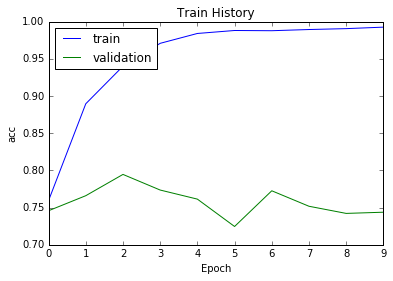

In [29]:
show_train_history(train_history,'acc','val_acc')

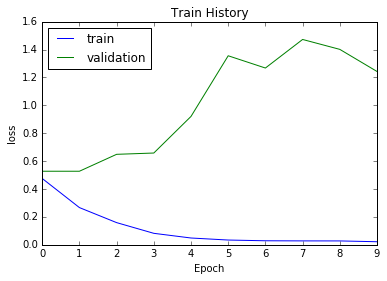

In [85]:
show_train_history(train_history,'loss','val_loss')